## Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Changing to Project directory

In [ ]:
import os
os.chdir("/content/drive/My Drive/data_science/computer_vision/session11_assignment/EVA5_AI_Projects_new-master")

## System allocated for Google Collab

In [ ]:
! nvidia-smi

Wed Oct  7 13:25:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Installing Third-Party Libraries

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-n6ysyr6m
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-n6ysyr6m
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19775 sha256=01ae9ab1d88356a9d8a0ffcae22cb964c188b9942030a03aec7a9c36842a41ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-lpc_swhs/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-npl9l_6b
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-npl9l_6b
     |████████████████████████████████| 952kB 4.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=69177 sha256=fddad4b293da167773d4e2a1bbdfcc6f6a81ca1df021638eaef659240752f445
  Stored in directory: /tmp/pip-ephem-wheel-cache-mj1chfx8/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install torch-lr-finder

In [ ]:
!pip install torchsummary

## Importing Standard, Third-party and User-defined Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import time
import torch
from torchsummary import summary
from torchvision.utils import make_grid, save_image
import torch.nn as nn
import torch.optim as optim

import hiddenlayer as hl

from configs import basic_config

from data.data_loaders.base_data_loader import BaseDataLoader
from data.base_data_utils import get_data_loaders
from data.base_data_utils import sample_data
from data.data_transforms.base_data_transforms import UnNormalize

from utils.misc_utils import get_device_type, current_config
from utils.visualization_utils import plot_multigraph, plot_misclassified_images, plot_LR_graph, visualize_clr
from utils import logger_utils

from models.networks.resnet_davidnet import ResNetDavidNet
# from models.networks.resnet_davidnet_lr_finder import ResNetDavidNet as ResNetDavidNet_lrf
from models.model_builder import build_model
from models.gradcam.utils import visualize_cam
from models.gradcam.gradcam import GradCAM
from models.gradcam.gen_gradcam import generate_grad_cam_grid,generate_missclassified_gradcam_grid
from models.learning_rates.lr_range_test import LRRangeFinder
from models.build_graph import draw_graph


from orchestrators.base_orchestrator import start_training
from orchestrators.base_orchestrator import display_classwise_accuracy

## Configuration for the project

In [ ]:
current_config()

EPOCHS - 24
OrderedDict - <class 'collections.OrderedDict'>
SEED - 1
agumentation_package - Albumentation
cuda - True
data - {'img_augs': OrderedDict([('PadIfNeeded', {'min_height': 40, 'min_width': 40, 'border_mode': 0, 'value': (0.4914, 0.4822, 0.4465), 'p': 1.0}), ('oneof_crop', {'randomcrop': {'height': 32, 'width': 32, 'p': 0.9}, 'centercrop': {'height': 32, 'width': 32, 'p': 0.1}, 'p': 1.0}), ('fliplr', {'p': 0.2}), ('cutout', {'num_holes': 1, 'max_h_size': 8, 'max_w_size': 8, 'fill_value': (0.4914, 0.4822, 0.4465), 'always_apply': False, 'p': 0.1})]), 'normalize_paras': [(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.201)], 'dataloader_args': {'shuffle': True, 'batch_size': 512, 'num_workers': 16, 'pin_memory': True}, 'data_kind': {'dataset_type': 'open_datasets', 'dataset_name': 'CIFAR10', 'datasets_location': 'data/datasets'}}
l1_lambda - 0.0
logger_config - {'log_filename': 'logs/Session11_assignment', 'level': 20, 'format': '%(asctime)s %(levelname)-8s [%(filename)s:%(lineno)d

## Setting Logger

In [ ]:
logger = logger_utils.get_logger(__name__)

## Creating Train and Test Data Loaders

In [ ]:
train_loader, test_loader = get_data_loaders(dataset_name='cifar10')


**** Started Loading data ****

Files already downloaded and verified
CUDA Available? True
Files already downloaded and verified
CUDA Available? True
CUDA Available? True

**** Ended Loading data ****



## Peek at Sample Data

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

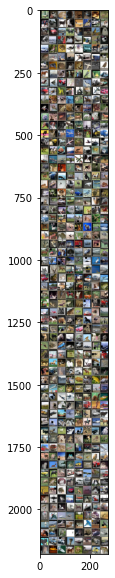

 deer   dog   cat   cat


In [ ]:
sample_data(train_loader, classes)

## Plotting CLR(Cyclic LR) 

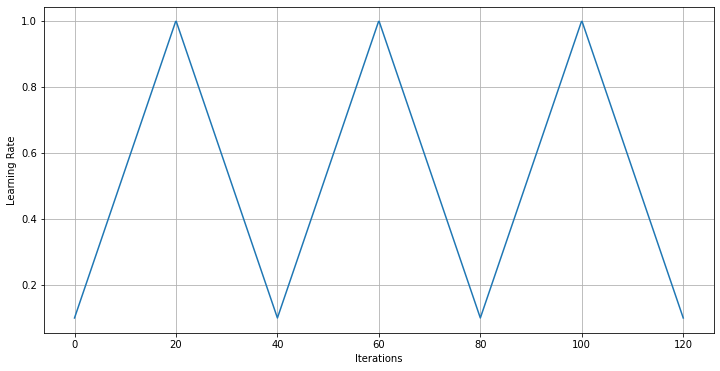

In [ ]:
# 2 x step_size = 1 cycle
num_cycles = 3
step_size = 20
lr_min = 0.1
lr_max = 1.0
visualize_clr(num_cycles, step_size, lr_min, lr_max)

## Creating Model

In [ ]:
def get_model():
  device = get_device_type()
  return ResNetDavidNet().to(device)

In [ ]:
model = get_model()

## Network Summary

In [ ]:
def print_summary(network,title):
  print(title)
  summary(network,input_size=(3,32,32))

In [ ]:
print_summary(model,'Network summary')

Network summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14   

## Plotting Network Graph

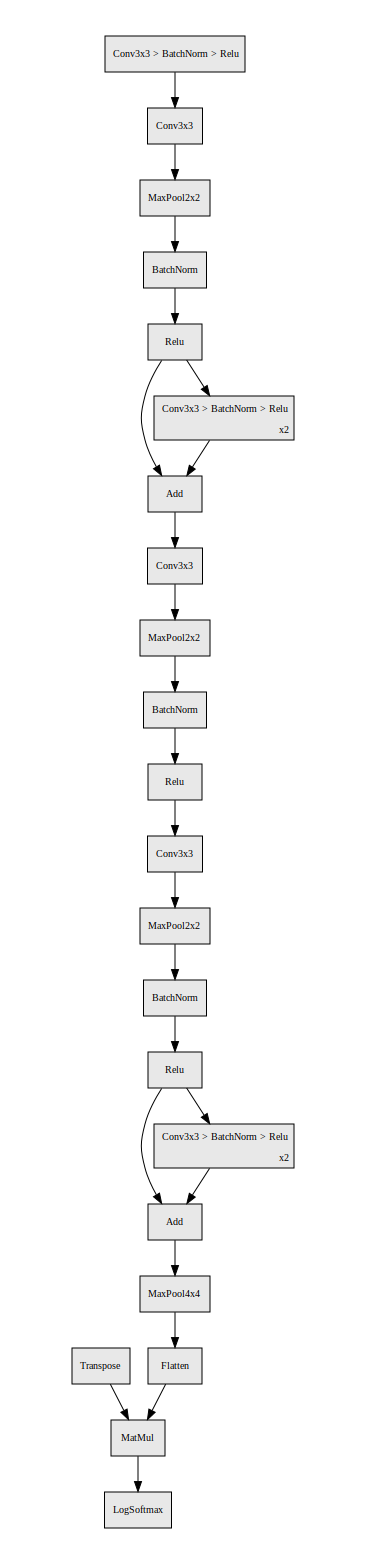

In [ ]:
device = get_device_type()
input = torch.zeros([1, 3, 32, 32]).to(device)
draw_graph(model, input, view='TD')

## LR Range Test in Linear and Exponential step modes

In [ ]:
def lr_range_test(model,start_lr, end_lr, step_mode, epochs, sgd_lr=5.34E-02, sgd_momentum=0.9):
  print(f'\n\n***** Started LR Test with step_mode={step_mode}, start_lr={start_lr}, end_lr={end_lr} *****\n\n')
  criterion = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr=sgd_lr, momentum=sgd_momentum)
  lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
  lr_finder.range_test(train_loader, val_loader=test_loader, start_lr=start_lr, end_lr=end_lr,
                      epochs=epochs, step_mode=step_mode)
  lr_finder.plot(metric='acc', skip_start=0, skip_end=0)
  lr_finder.reset()
  best_acc = lr_finder.best_acc
  best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
  print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))
  print(f'\n\n***** Ended LR Test with step_mode={step_mode}, start_lr={start_lr}, end_lr={end_lr} *****\n\n')
  return best_acc, best_lr

In [ ]:
linear_lr_pairs = [(1E-6, 0.02),]  ## Add pairs for lr range test in linear mode
exp_lr_pairs = [(1E-7,1E-1),] ## Add pairs for lr range test in exponential mode



***** Started LR Test with step_mode=linear, start_lr=1e-06, end_lr=0.02 *****





Learning rate search finished. See the graph with {finder_name}.plot()


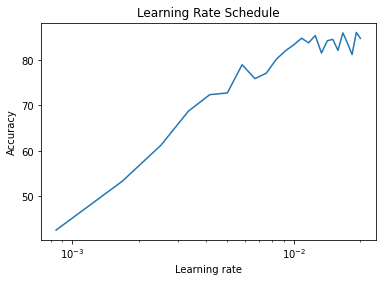

Best Accuracy: 86.03
Best Learning Rate: 0.01917521130952381


***** Ended LR Test with step_mode=linear, start_lr=1e-06, end_lr=0.02 *****




In [ ]:
## Linear Step Mode
for start_lr, end_lr in linear_lr_pairs:
  model = get_model()
  lr_range_test(model, start_lr, end_lr, 'linear', 24, sgd_lr=5.34E-02, sgd_momentum=0.9)  

In [ ]:
# ## Exponential Step Mode
# for start_lr, end_lr in exp_lr_pairs:
#   model = get_model()
#   lr_range_test(model, start_lr, end_lr, 'exp', 24, sgd_lr=5.34E-02, sgd_momentum=0.9)  

## Preparing for Training

In [ ]:
## Preparing for training
device = get_device_type()
model = get_model()

EPOCHS = basic_config.EPOCHS
device = get_device_type()
results = {}

models_dict = {'resnet_davidnet': {'model': model}
          }


In [ ]:
## Used max_lr = 0.01917521130952381 (from lr_range_test) and divide_factor=8

In [ ]:
0.01917521130952381/8.0 #min_lr

0.0023969014136904763

## Start Training

In [ ]:
## Start Training
results = start_training(EPOCHS, device, train_loader, test_loader, **models_dict)

  0%|          | 0/98 [00:00<?, ?it/s]


**** Started training ****


Model: resnet_davidnet

0 0
Optimizer paras: optimizer=sgd, lr=0.0534,momentum=0.9, weight_decay=0.0
LR Scheduler paras: {'max_lr': 0.01917521130952381, 'epochs': 24, 'pct_start': 0.20833333333333334, 'steps_per_epoch': 98, 'cycle_momentum': False, 'div_factor': 8, 'final_div_factor': 1, 'anneal_strategy': 'linear', 'name': 'OneCycleLR'}
[EPOCH:1]

Current LR: 0.0023969014136904763



Epoch=1 Iteration=98 Loss=1.2326147556304932 Batch_id=97 Current_train_batch_accuracy=42.52: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Train set: Average loss: 1.2432, Accuracy: 27910/50000 (55.82%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2460, Accuracy: 5569/10000 (55.69%)

best_test_accuracy 55.69
[EPOCH:2]

Current LR: 0.0057594256872930665



Epoch=2 Iteration=196 Loss=1.0046743154525757 Batch_id=97 Current_train_batch_accuracy=62.80: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]



Train set: Average loss: 1.0385, Accuracy: 32075/50000 (64.15%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0535, Accuracy: 6471/10000 (64.71%)

best_test_accuracy 64.71
[EPOCH:3]

Current LR: 0.009121949960895657



Epoch=3 Iteration=294 Loss=0.7589724659919739 Batch_id=97 Current_train_batch_accuracy=70.16: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Train set: Average loss: 0.9425, Accuracy: 34574/50000 (69.15%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0160, Accuracy: 6815/10000 (68.15%)

best_test_accuracy 68.15
[EPOCH:4]

Current LR: 0.012484474234498246



Epoch=4 Iteration=392 Loss=0.6852269172668457 Batch_id=97 Current_train_batch_accuracy=74.53: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Train set: Average loss: 0.9385, Accuracy: 35772/50000 (71.54%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0584, Accuracy: 7059/10000 (70.59%)

best_test_accuracy 70.59
[EPOCH:5]

Current LR: 0.015846998508100837



Epoch=5 Iteration=490 Loss=0.7190311551094055 Batch_id=97 Current_train_batch_accuracy=77.72: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Train set: Average loss: 0.6130, Accuracy: 39899/50000 (79.80%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6946, Accuracy: 7777/10000 (77.77%)

best_test_accuracy 77.77
[EPOCH:6]

Current LR: 0.019166200401953545



Epoch=6 Iteration=588 Loss=0.5127533078193665 Batch_id=97 Current_train_batch_accuracy=79.90: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Train set: Average loss: 0.6012, Accuracy: 40116/50000 (80.23%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7485, Accuracy: 7804/10000 (78.04%)

best_test_accuracy 78.04
[EPOCH:7]

Current LR: 0.018283131460067582



Epoch=7 Iteration=686 Loss=0.4215909540653229 Batch_id=97 Current_train_batch_accuracy=84.82: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Train set: Average loss: 0.4267, Accuracy: 42665/50000 (85.33%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5640, Accuracy: 8223/10000 (82.23%)

best_test_accuracy 82.23
[EPOCH:8]

Current LR: 0.017400062518181617



Epoch=8 Iteration=784 Loss=0.3915654718875885 Batch_id=97 Current_train_batch_accuracy=87.91: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Train set: Average loss: 0.3301, Accuracy: 44175/50000 (88.35%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5078, Accuracy: 8391/10000 (83.91%)

best_test_accuracy 83.91
[EPOCH:9]

Current LR: 0.01651699357629565



Epoch=9 Iteration=882 Loss=0.3114202320575714 Batch_id=97 Current_train_batch_accuracy=89.31: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Train set: Average loss: 0.2650, Accuracy: 45433/50000 (90.87%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4289, Accuracy: 8653/10000 (86.53%)

best_test_accuracy 86.53
[EPOCH:10]

Current LR: 0.015633924634409685



Epoch=10 Iteration=980 Loss=0.1860385686159134 Batch_id=97 Current_train_batch_accuracy=91.31: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Train set: Average loss: 0.2439, Accuracy: 45650/50000 (91.30%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4663, Accuracy: 8598/10000 (85.98%)

best_test_accuracy 86.53
[EPOCH:11]

Current LR: 0.014750855692523721



Epoch=11 Iteration=1078 Loss=0.1530444622039795 Batch_id=97 Current_train_batch_accuracy=92.67: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Train set: Average loss: 0.2341, Accuracy: 45894/50000 (91.79%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4623, Accuracy: 8646/10000 (86.46%)

best_test_accuracy 86.53
[EPOCH:12]

Current LR: 0.013867786750637757



Epoch=12 Iteration=1176 Loss=0.18355360627174377 Batch_id=97 Current_train_batch_accuracy=93.80: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]



Train set: Average loss: 0.1713, Accuracy: 47021/50000 (94.04%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4052, Accuracy: 8782/10000 (87.82%)

best_test_accuracy 87.82
[EPOCH:13]

Current LR: 0.012984717808751791



Epoch=13 Iteration=1274 Loss=0.14647896587848663 Batch_id=97 Current_train_batch_accuracy=94.48: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]



Train set: Average loss: 0.1337, Accuracy: 47695/50000 (95.39%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3793, Accuracy: 8901/10000 (89.01%)

best_test_accuracy 89.01
[EPOCH:14]

Current LR: 0.012101648866865825



Epoch=14 Iteration=1372 Loss=0.12769797444343567 Batch_id=97 Current_train_batch_accuracy=95.47: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Train set: Average loss: 0.1381, Accuracy: 47652/50000 (95.30%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3982, Accuracy: 8825/10000 (88.25%)

best_test_accuracy 89.01
[EPOCH:15]

Current LR: 0.011218579924979861



Epoch=15 Iteration=1470 Loss=0.11050306260585785 Batch_id=97 Current_train_batch_accuracy=96.11: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Train set: Average loss: 0.1589, Accuracy: 47077/50000 (94.15%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4387, Accuracy: 8759/10000 (87.59%)

best_test_accuracy 89.01
[EPOCH:16]

Current LR: 0.010335510983093897



Epoch=16 Iteration=1568 Loss=0.08797964453697205 Batch_id=97 Current_train_batch_accuracy=96.59: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]



Train set: Average loss: 0.0851, Accuracy: 48639/50000 (97.28%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3706, Accuracy: 8917/10000 (89.17%)

best_test_accuracy 89.17
[EPOCH:17]

Current LR: 0.009452442041207933



Epoch=17 Iteration=1666 Loss=0.09042415767908096 Batch_id=97 Current_train_batch_accuracy=97.19: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Train set: Average loss: 0.0770, Accuracy: 48743/50000 (97.49%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3685, Accuracy: 8966/10000 (89.66%)

best_test_accuracy 89.66
[EPOCH:18]

Current LR: 0.008569373099321967



Epoch=18 Iteration=1764 Loss=0.1307085156440735 Batch_id=97 Current_train_batch_accuracy=97.53: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Train set: Average loss: 0.0757, Accuracy: 48777/50000 (97.55%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3705, Accuracy: 8977/10000 (89.77%)

best_test_accuracy 89.77
[EPOCH:19]

Current LR: 0.0076863041574360014



Epoch=19 Iteration=1862 Loss=0.05552378296852112 Batch_id=97 Current_train_batch_accuracy=97.74: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Train set: Average loss: 0.0644, Accuracy: 48993/50000 (97.99%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3785, Accuracy: 8954/10000 (89.54%)

best_test_accuracy 89.77
[EPOCH:20]

Current LR: 0.006803235215550037



Epoch=20 Iteration=1960 Loss=0.04546854645013809 Batch_id=97 Current_train_batch_accuracy=98.16: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Train set: Average loss: 0.0536, Accuracy: 49186/50000 (98.37%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3486, Accuracy: 9000/10000 (90.00%)

best_test_accuracy 90.0
[EPOCH:21]

Current LR: 0.005920166273664072



Epoch=21 Iteration=2058 Loss=0.10296405106782913 Batch_id=97 Current_train_batch_accuracy=98.26: 100%|██████████| 98/98 [00:31<00:00,  3.06it/s]



Train set: Average loss: 0.0516, Accuracy: 49208/50000 (98.42%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3622, Accuracy: 9003/10000 (90.03%)

best_test_accuracy 90.03
[EPOCH:22]

Current LR: 0.0050370973317781075



Epoch=22 Iteration=2156 Loss=0.0955134779214859 Batch_id=97 Current_train_batch_accuracy=98.56: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Train set: Average loss: 0.0448, Accuracy: 49342/50000 (98.68%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3487, Accuracy: 9033/10000 (90.33%)

best_test_accuracy 90.33
[EPOCH:23]

Current LR: 0.004154028389892142



Epoch=23 Iteration=2254 Loss=0.030153373256325722 Batch_id=97 Current_train_batch_accuracy=98.72: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Train set: Average loss: 0.0394, Accuracy: 49415/50000 (98.83%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3385, Accuracy: 9078/10000 (90.78%)

best_test_accuracy 90.78
[EPOCH:24]

Current LR: 0.0032709594480061777



Epoch=24 Iteration=2352 Loss=0.030340882018208504 Batch_id=97 Current_train_batch_accuracy=98.96: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]



Train set: Average loss: 0.0354, Accuracy: 49508/50000 (99.02%)


Test set: Average loss: 0.3346, Accuracy: 9077/10000 (90.77%)

best_test_accuracy 90.78

results : {'resnet_davidnet': [[55.82, 64.15, 69.148, 71.544, 79.798, 80.232, 85.33, 88.35, 90.866, 91.3, 91.788, 94.042, 95.39, 95.304, 94.154, 97.278, 97.486, 97.554, 97.986, 98.372, 98.416, 98.684, 98.83, 99.016], [1.2431576190185547, 1.0385353790283203, 0.9424775115966797, 0.9384681231689453, 0.6130474996948242, 0.6012270077514649, 0.42666424530029295, 0.33010207244873047, 0.2650343409729004, 0.24386708221435546, 0.2340776294708252, 0.1713255601501465, 0.13374039375305175, 0.1381196189880371, 0.15892813262939454, 0.08509655796051026, 0.07699686714172363, 0.07570389167785645, 0.06438600833892823, 0.05361685308456421, 0.05161113998413086, 0.044797531623840335, 0.039380237922668454, 0.035354459285736085], [55.69, 64.71, 68.15, 70.59, 77.77, 78.04, 82.23, 83.91, 86.53, 85.98, 86.46, 87.82, 89.01, 88.25, 87.59, 89.17, 89.66, 89.77, 8

In [ ]:
torch.save(model, f'check_points/Session11_assignment_epochs_{EPOCHS}.h5')

## Preparing results for plotting

In [ ]:
lst_plottingJobs_acc = []
lst_plottingLegends_acc = []
lst_plotting_loss = []
lst_plottingLegends_loss = []
lst_plotting_lr = []
lst_plottingLegends_lr = []

for model_type in results:
  lst_plottingJobs_acc.append(results[model_type][0])
  lst_plottingJobs_acc.append(results[model_type][2])
  
  lst_plottingLegends_acc.append('Training accuracy')
  lst_plottingLegends_acc.append('Validation accuracy')

  lst_plotting_loss.append(results[model_type][1])
  lst_plotting_loss.append(results[model_type][3])

  lst_plottingLegends_loss.append('Training loss')
  lst_plottingLegends_loss.append('Validation loss')

  lst_plotting_lr.append(results[model_type][5])
  lst_plottingLegends_lr.append('Learning Rate')

## Plotting model evaluation results


**** Started Plotting multigraph ****



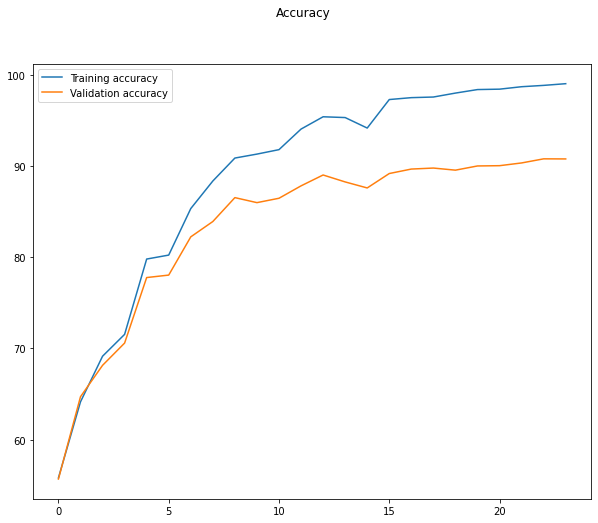


**** Ended Plotting multigraph ****



In [ ]:
plot_multigraph(lst_plottingJobs_acc,lst_plottingLegends_acc,title="Accuracy")


**** Started Plotting multigraph ****



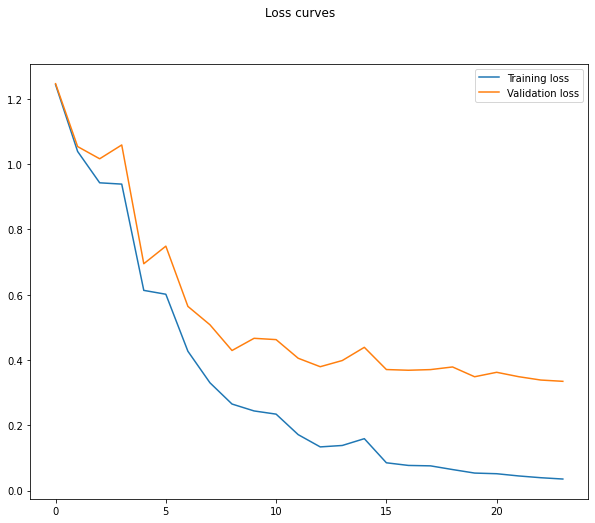


**** Ended Plotting multigraph ****



In [ ]:
plot_multigraph(lst_plotting_loss,lst_plottingLegends_loss,title="Loss curves")

## Plotting Change in Learning rate during model training


**** Started Plotting multigraph ****



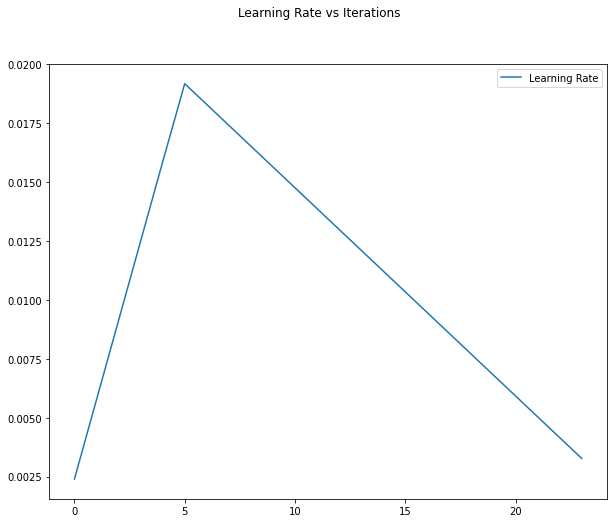


**** Ended Plotting multigraph ****



In [ ]:
plot_multigraph(lst_plotting_lr,lst_plottingLegends_lr,title="Learning Rate vs Iterations")

## Plotting Loss curve at different learning rates during the model Training


**** Started Plotting Graph ****



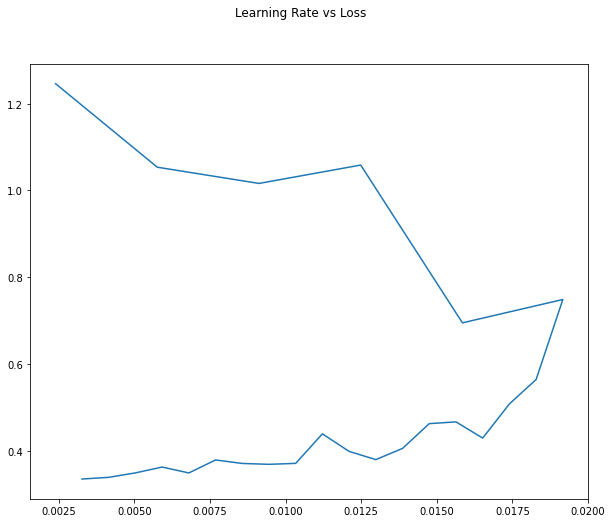


**** Ended Plotting multigraph ****



In [ ]:
plot_LR_graph(results[model_type][3],results[model_type][5],'Learning Rate vs Loss')

In [ ]:
#model =torch.load(f'check_points/Session10_assignment_epochs_10.h5')

## Classwise accuracies

In [ ]:
display_classwise_accuracy(test_loader,device,model,classes)

Accuracy of plane : 100.0
Accuracy of car : 100.0
Accuracy of bird : 84.61538461538461
Accuracy of cat : 50.0
Accuracy of deer : 87.5
Accuracy of dog : 72.72727272727273
Accuracy of frog : 100.0
Accuracy of horse : 100.0
Accuracy of ship : 100.0
Accuracy of truck : 100.0


In [ ]:
# configs = [dict(model_type='resnet', arch=model, layer_name='layer4')]

In [ ]:
## Misclassified images, but we observed mislabled images as well.
# generate_grad_cam_grid(configs, classes, test_loader, device, model, matched=False, num_img=25)

In [ ]:
## Correctly classsified images
# generate_grad_cam_grid(configs, classes, test_loader, device, model, matched=True, num_img=3)

In [ ]:
# generate_missclassified_gradcam_grid(configs, classes, test_loader, device, model, matched=True, num_of_images=25)